In [1]:
import os
import cv2
import imutils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
from scipy.spatial import distance
import ipywidgets as widgets
figsize(15, 6)
%matplotlib inline

import sys
sys.path.insert(0, '/home/bl9/gempy')

import gempy.hackathon as hk

Devito is not working


/home/bl9/gempy/gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


Freenect is not installed. Sandbox wont work. Good luck


In [2]:
images = []
for img in os.listdir("test_images/"):
    im = cv2.imread("test_images/"+img)
    images.append(im)
  
images = np.array(images)[:, 80:240 ,230:450]

In [6]:
def where_shapes(image, min_area=30):
    bilateral_filtered_image = cv2.bilateralFilter(image, 5, 175, 175)
    
    gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 80, 255, cv2.THRESH_BINARY)[1]
    edge_detected_image = cv2.Canny(thresh, 75, 200)
    
    _, contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_list = []
    contour_coords = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX = 0
            cY = 0
        
        approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
        area = cv2.contourArea(contour)
        if ((len(approx) > 8) & (len(approx) < 23) & (area > min_area) ):
            contour_list.append(contour)
            contour_coords.append([cX,cY])
            
    return np.array(contour_coords)


def where_circles(image, thresh_value=80):
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, thresh_value, 255, cv2.THRESH_BINARY)[1]
    #circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2 100)
    circles = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT, 1, 2, np.array([]), 200, 8, 4, 8)
    
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        #print(circles)
        circle_coords = np.array(circles)[:,:2]
        dist = distance.cdist(circle_coords, circle_coords, 'euclidean')
        minima = np.min(dist, axis=1)
        dist_bool = (dist > 0) & (dist < 5)
        pos = np.where(dist_bool==True)[0]
        grouped = circle_coords[pos]
        mean_grouped = (np.sum(grouped, axis=0)/2).astype(int)
        circle_coords = np.delete(circle_coords,list(pos), axis=0)
        circle_coords = np.vstack((circle_coords, mean_grouped))
        
        return circle_coords

def filter_circles(shape_coords, circle_coords):
    dist = distance.cdist(shape_coords, circle_coords, 'euclidean')
    minima = np.min(dist, axis=1)
    non_circle_pos = np.where(minima>10)
    return non_circle_pos

def where_non_circles(image):
    shape_coords = where_shapes(image)
    circle_coords = where_circles(image)
    non_circles = filter_circles(shape_coords, circle_coords)
    return shape_coords[non_circles]
    
def get_shape_coords(image):
    non_circles = where_non_circles(image)
    circles = where_circles(image)
    return non_circles.tolist(), circles

def plot_all_shapes(image):
    output = image.copy()
    non_circles, circles = get_shape_coords(image)
    for (x, y) in circles:
        cv2.circle(output, (x, y), 5, (0, 255, 0), 3)
            #cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    for (x, y) in non_circles:
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    out_image=np.hstack([image, output])   
    plt.imshow(out_image)  

In [ ]:
circles = get_shape_coords(images[5])[1]
non_circles = get_shape_coords(images[5])[0]

In [ ]:
type(non_circles)

In [ ]:
figsize(15,6)
plot_all_shapes(images[0])

In [ ]:
hk.plot_all_shapes(images[5], thresh_value=80)

In [ ]:
thresh_widget = widgets.interactive(plot_all_shapes,
                                                 thresh_value=widgets.IntSlider(
                                                     value=80, min=0, max=150, step=1,continuous_update=False))

In [ ]:
display(thresh_widget)

In [ ]:
w = widgets.IntSlider(
    value=80,
    min=0,
    max=150,
    step=1,
    description='Treshold Value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [ ]:
display(w)

In [ ]:
thresh_value=80
min_area = 30

bilateral_filtered_image = cv2.bilateralFilter(images[5], 5, 175, 175)
    
gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 80, 255, cv2.THRESH_BINARY)[1]
edge_detected_image = cv2.Canny(thresh, 75, 200)

_, contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

M_list = []
contour_list = []
contour_coords = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX = 0
        cY = 0
    
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 23) & (area > min_area) ):
        contour_list.append(contour)
        contour_coords.append([cX,cY])

In [ ]:
cv2.drawContours?

In [ ]:
np.array(contour_list).shape

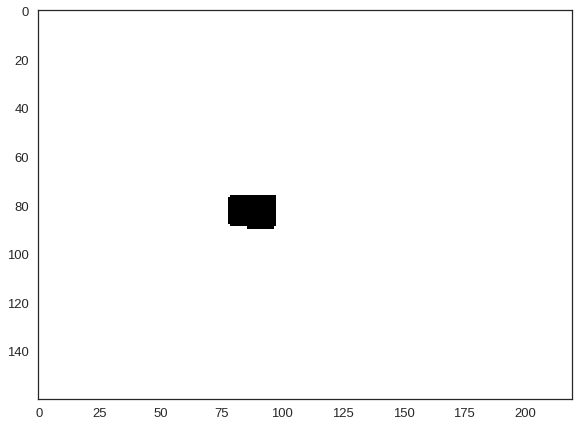

In [19]:
imcopy = images[5].copy()
bilateral_filtered_image = cv2.bilateralFilter(imcopy, 5, 175, 175)
gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 1, cv2.THRESH_BINARY)[1]
threshcopy = thresh.copy()
circle_coords = where_circles(images[5], thresh_value=80)
for (x, y) in circle_coords:
        cv2.circle(threshcopy, (x, y), 20, 1, -1)


plt.imshow(np.invert(threshcopy.astype(bool)))
plt.show()

In [ ]:
np.unique(np.invert(threshcopy.astype(bool)))

In [9]:
hk.non_circles_fillmask(images[5],th1=60, th2=80)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

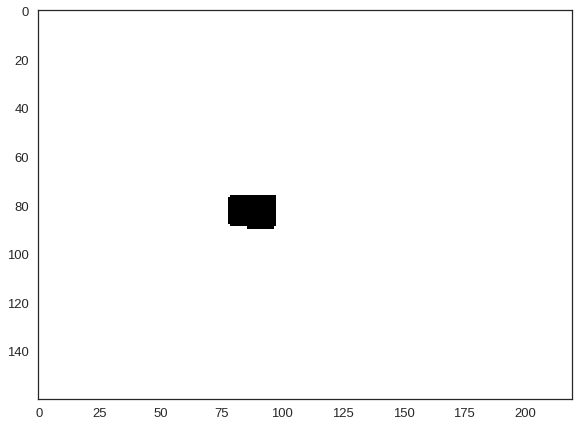

In [8]:
plt.imshow(hk.non_circles_fillmask(images[5],th1=60, th2=80))
plt.show()